In [1]:
import pandas as pd
import numpy as np
import sklearn.linear_model as lm
import matplotlib.pyplot as plt

%matplotlib inline

# 1 Regresión Lineal Ordinaria (LSS)

Se comenzará el informe con la contrucción de un modelo para precedir el precio de una casa. Como datos de entrada se usará un *dataset* con las ventas en el condado de King County, EEUU entre Mayo de 2014 y Mayo de 2015. Para esto, se utilizará una regresión lineal ordinaria basada en LSS (Linear Least Squares)

## a) Ingreso de los datos

Los datos fueron obtenidos de Kaggle, y se encuentran en un archivo CSV. Las características o *features* id (número identificador), date (fecha) y zipcode (código postal) serán descartadas ya que de ante mano podemos suponer que no tienen relación con el precio de la casa.

In [2]:
df = pd.read_csv("kc_house_data.csv", sep = ",", header = 0)
df = df.drop(['id','date','zipcode'], axis=1)

## b) Análisis Descriptivo de los Datos

Primero es útil revisar el tamaño del dataset, junto con todo el resto de las características.

In [3]:
df.shape

(21613, 18)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21613 entries, 0 to 21612
Data columns (total 18 columns):
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
lat              21613 non-null float64
long             21613 non-null float64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: float64(5), int64(13)
memory usage: 3.1 MB


In [5]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
count,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,540088.141767,3.370842,2.114757,2079.899736,15106.967566,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,47.560053,-122.213896,1986.552492,12768.455652
std,367127.196483,0.930062,0.770163,918.440897,41420.511515,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,0.138564,0.140828,685.391304,27304.179631
min,75000.000000,0.000000,0.000000,290.000000,520.000000,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,47.155900,-122.519000,399.000000,651.000000
25%,321950.000000,3.000000,1.750000,1427.000000,5040.000000,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,450000.000000,3.000000,2.250000,1910.000000,7618.000000,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,645000.000000,4.000000,2.500000,2550.000000,10688.000000,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,47.678000,-122.125000,2360.000000,10083.000000
max,7700000.000000,33.000000,8.000000,13540.000000,1651359.000000,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,47.777600,-121.315000,6210.000000,871200.000000


## c) Transformación de las Variables

Los modelos de regresión lineal múltiple asumen ciertas cosas sobre el *dataset*:

* Las variables dependientes e independientes tienen una relación lineal
* Las variables siguen una distribución normal

Una función entregada por SciKit que nos puede ayudar para el segundo punto es StandardScaler, el cual hace lo que se llama Estandarización o Z-score normalization. Esto es, transformar las variables en sus z-scores a partir de:

$$x - \mu \over \sigma$$

Siendo $\mu$ el promedio de la población y $\sigma$ la desviación estándar de ésta. Esto va a permitir que los datos tengan una media o esperanza centrada en 0, y varianzas bajo el mismo orden de magnitud.

Para el caso de nuestra variable dependiente **precio**, se va a hacer además una transformación logarítmica. Ésta es una práctica común al trabajar con variables referidas a dinero, y tiene varias ventajas:

* Los precios en general tienen *skewness*, o sea, su histograma está desbalanceado, con la mayor parte de los datos acumulados en cierto rango de valores. Una transformacion logarítmica puede ayudar a balancear el histograma (mejorar la simetría), y hacer que su comportamiento sea similar a una distribución normal.
* Los cambios en el valor logarítmico de una variable pueden ser directamente interpretados como cambios porcentuales.
* El logaritmo puede convertir relaciones multiplicativas en relaciones aditivas (como en el caso anterior, donde los cambios son convertidos en adiciones), y por tanto, hace que patrones de crecimiento exponencial se conviertan en patrones lineales, los cuales funcionan mucho mejor con nuestro modelo.

http://www.jerrydallal.com/lhsp/logs.htm
https://www.r-statistics.com/2013/05/log-transformations-for-skewed-and-wide-distributions-from-practical-data-science-with-r/
https://people.duke.edu/~rnau/411log.htm


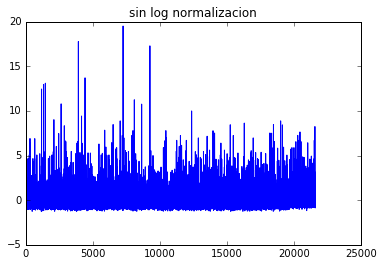

In [24]:
# ESTO ES EXPERIMENTACION, BORRAR DE AHI. TODO.

from sklearn.preprocessing import StandardScaler

#Estandarizacion del dataset
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

#df_scaled['price'] = np.log(df['price'])

#plt.plot(np.arange(1,200), df_scaled['price'][0:199])
plt.plot(np.arange(1,21614), df_scaled['price'])
plt.title('sin log normalizacion')
plt.show()


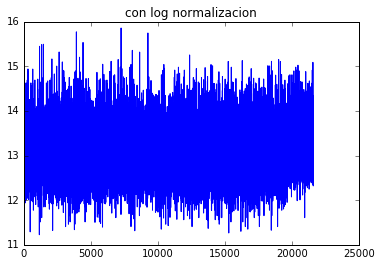

In [18]:
# ESTO ES EXPERIMENTACION, BORRAR DE AHI. TODO.

df_scaled['price'] = np.log(df['price'])

#plt.plot(np.arange(1,200), df_scaled['price'][0:199])
plt.plot(np.arange(1,21614), df_scaled['price'])
plt.title('con log normalizacion')
plt.show()


In [26]:
from sklearn.preprocessing import StandardScaler

#Estandarizacion del dataset
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

#Transformacion Logaritmica
df_scaled['price'] = np.log(df['price'])

In [27]:
df_scaled.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
count,21613.000000,2.161300e+04,2.161300e+04,2.161300e+04,2.161300e+04,2.161300e+04,2.161300e+04,2.161300e+04,2.161300e+04,2.161300e+04,2.161300e+04,2.161300e+04,2.161300e+04,2.161300e+04,2.161300e+04,2.161300e+04,2.161300e+04,2.161300e+04
mean,13.047817,-1.254167e-15,-1.051951e-15,3.174253e-16,3.281921e-17,-1.753125e-14,1.482989e-15,1.853096e-15,-2.636807e-15,-2.328998e-15,3.892022e-16,-2.022801e-15,3.592925e-15,4.348961e-15,-3.446807e-14,-3.637898e-14,-1.506632e-16,1.235382e-16
std,0.526685,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00
min,11.225243,-3.624404e+00,-2.745920e+00,-1.948891e+00,-3.521759e-01,-9.154270e-01,-8.717263e-02,-3.057595e-01,-3.702668e+00,-5.663344e+00,-1.809494e+00,-6.586810e-01,-2.417383e+00,-2.101284e-01,-2.916795e+00,-2.166543e+00,-2.316325e+00,-4.438052e-01
25%,12.682152,-3.987371e-01,-4.736214e-01,-7.108948e-01,-2.430487e-01,-9.154270e-01,-8.717263e-02,-3.057595e-01,-6.291869e-01,-5.588357e-01,-7.226314e-01,-6.586810e-01,-6.810785e-01,-2.101284e-01,-6.426977e-01,-8.102505e-01,-7.244971e-01,-2.808593e-01
50%,13.017003,-3.987371e-01,1.756067e-01,-1.849914e-01,-1.808075e-01,1.053939e-02,-8.717263e-02,-3.057595e-01,-6.291869e-01,-5.588357e-01,-2.758102e-01,-6.586810e-01,1.360059e-01,-2.101284e-01,8.478232e-02,-1.143518e-01,-2.138280e-01,-1.885636e-01
75%,13.377006,6.764851e-01,5.002207e-01,5.118578e-01,-1.066880e-01,9.365058e-01,-8.717263e-02,-3.057595e-01,9.075535e-01,2.919156e-01,5.091458e-01,6.066704e-01,8.849999e-01,-2.101284e-01,8.512345e-01,6.312541e-01,5.448802e-01,-9.835556e-02
max,15.856731,3.185793e+01,7.641730e+00,1.247807e+01,3.950434e+01,3.714405e+00,1.147149e+01,4.914129e+00,2.444294e+00,4.545672e+00,9.204044e+00,1.023238e+01,1.497813e+00,4.806428e+00,1.570054e+00,6.383070e+00,6.162239e+00,3.144029e+01


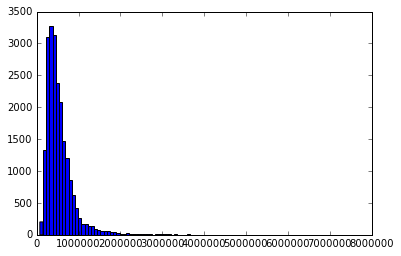

In [45]:
plt.hist(df['price'], bins=100)
plt.show()

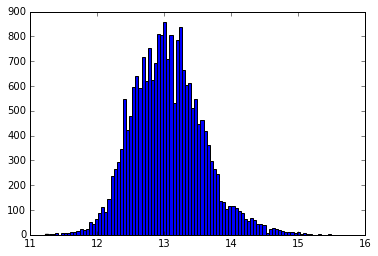

In [38]:
plt.hist(df_scaled['price'], bins=100)
plt.show()

Como vemos, logramos hacer que la media de las variables independientes sea muy cercana a cero, y que logre seguir distribuciones parecidas a una gaussiana. Para el caso de la variable de precio, obtuvimos una escala distinta, pero también de tipo gaussiana.

## d) Contrucción del Modelo

A continuación se hará la regresión lineal. Recordando que la regresión lineal múltiple se puede ver como la resolución de un sistema de ecuaciones, donde cada elemento del conjunto de respuestas se puede ver como:

$$y_i = \beta_0 1 + \beta_1 x_{i1} + \cdots + \beta_q x_{iq} + \varepsilon_i$$

Sea $n$ el tamaño de la muestra (aquí, 21613) y $q$ el número de parámetros (aquí, 18). La ecuación de regresión lineal múltiple es:

$$ \large Y_{n \times 1} = X_{n \times q} \, \beta_{q \times 1} \, + \, \epsilon_{n \times 1}$$

Donde
* $Y$ es un vector de tamaño $n\times 1$, se le dice *vector de respuesta*
* $\epsilon$ es un vector de tamaño $n\times 1$, se le dice *vector de errores*
* $X$ es una matriz de tamaño $n\times q$, se le dice *matriz de diseño*
* $\beta$ es un vector de tamaño $q\times 1$, se le dice *vector de pendiente*

http://dept.stat.lsa.umich.edu/~kshedden/Courses/Stat401/Notes/401-multreg.pdf

A la función LinearRegression le enviamos el parámetro **fit_intercept = False** debido a que los datos de precios ya están centrados (tienen intercepto en cero) TODO REVISAR ESTO PORQUE NO ESTOY DEL TODO SEGURO

In [71]:
#Se guarda en la variable X todo el dataset menos la columna "price"
X = df_scaled.iloc[:,1:]
#Se registra la cantidad de filas en la variable N
N = X.shape[0]
# Se le agrega al dataframe X la columna "intercept" llena de 1s
X.insert(X.shape[1], 'intercept', np.ones(N))
# Se guarda la columna "price" del dataframe estandarizado en y
y = df_scaled['price']
# Se crea un vector de 0s del largo del dataframe X
mask = np.zeros(len(X))
# Se crea la variable limit con el 70% del largo del dataframe X
limit = int(len(X)*0.7)
# Se setea con el valor 1 de 0 hasta limit los campos del vector mask
mask[:limit] = 1
# Se crea un vector que indica si la data es de entrenamiento o no
istrain = mask == 1
# Se genera la data de entrenamiento usando el vector istrain aplicado a X e y
Xtrain = X[istrain]
ytrain = y[istrain]
# Se genera la data de test con el 30% restante de X e y
Xtest = X[np.logical_not(istrain)]
ytest = y[np.logical_not(istrain)]
#Se hace la regresion lineal usando los datos de entrenamiento
linreg = lm.LinearRegression(fit_intercept = False)
linreg.fit(Xtrain, ytrain)
#Coeficientes obtenidos con la regresion sobre los datos de entrenamiento
print('Coeficientes: \n', linreg.coef_)

Coeficientes: 
 [ -1.17271076e-02   5.81885886e-02  -1.58715935e+12   2.23001628e-02
   3.73612585e-02   3.32179130e-02   4.23151454e-02   4.59551654e-02
   1.85939556e-01   1.43102549e+12   7.64814719e+11  -1.10168457e-01
   1.51367188e-02   1.86401367e-01  -3.96728516e-03   8.58154297e-02
  -7.14111328e-03   1.30399399e+01]


In [72]:
# Precision de la prediccion 
linreg.score(Xtest,ytest)

0.76263638925086796

## e)

In [75]:
import scipy as sc
from scipy import stats

In [79]:
#z_scores  = sc.stats.zscore(X, axis=1, ddof=1)
#print(z_scores)